In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import ellipe
from scipy.special import ellipk
from scipy.interpolate import lagrange
from scipy.interpolate import InterpolatedUnivariateSpline

## User input

In [2]:
user = True
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
units = 'KPC,MSUN/PC**2'
zlaw = 2                            # Case 2: sech-squared density law
mode = zlaw                         # Density distribution mode
radii = np.arange(0.001,11,0.01)

# Parameters
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 1
z0 = 0.93
distance = 16.5                    # Distance in MPC
h = 10.0                           # GUESS: radial scale-length (KPC)
dens0 = 10**2.4                    # GUESS: central surface density (MSUN/PC^2): from Fig 8. Paper 13

## Density profile

In [3]:
def DensityProfile(user=user,raddens=raddens,units=units,mode=mode,dens0=dens0,h=h):
    
    ##################################
    # Case 1: Import density profile #
    ##################################
    
    if user == True:
        if units == 'KPC,MSUN/PC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

        if units == 'ARCSEC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # ARCSEC to KPC
            xdinp = 4.8481E-3 * distance * xdinp

            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp

        LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
        LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
        ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
        rcut = xdinp[ndinp-1]               # takes second to last radius value
        delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value
    
    
    #####################################
    # Case 2: Calculate density profile #
    #####################################
    
    if user == False:
    
        # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
        dens0 = dens0           # central density of exponential DISK
        # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
        #dens0 = 10**(-0.4 * dens0)       
        #dens0 = (4.8481E-3 * distance)**(-2) * dens0
        #dens0 = dens0 * 1.0e6        
        #print("dens0 = {:.4}".format(dens0))

        h = h                   # radial scale length
        z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                                  # note: The integration in Z is the most time consuming part
                                  # of the calculation. For example it takes about 0.2 seconds
                                  # to calculate a point on the rotation curve for a disk with zero
                                  # thickness, and about 2 seconds for a disk with non-zero thickness.
        rcut = 4*h              # cutoff radius
        delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                                  # to have a non-zero softening in case of a truncated disk, 
                                  # because then the sharp features in the calculated rotation 
                                  # curve will be smoothed out. A softening parameter of about 
                                  # 0.2 scale lengths would be sufficient.

        # Now calculate the surface densities
        LEN1 = 100
        LEN2 = 100
        xdinp = np.zeros(LEN2-1)    # radii surface density
        ydinp = np.zeros(LEN2-1)    # surface densities
        rdinp = rcut + delta      # max radius, where galaxy ends
        ndinp = LEN2 - 1          # number of surface densities
        xstep = rdinp / (ndinp - 1)        # step in radius

        i = 0                              # counter 
        while i < ndinp:
            # Casertano's piecewise function, where do they calculate partial derivative drho/du??
            xdinp[i] = x = xstep * i
            if x >= rcut and delta > 0.0:
                #y = -(1/delta) * dens0 * np.exp(-rcut/h)
                y = dens0 * np.exp(-rcut/h)*(rcut+delta-x)/delta
            elif x >= rdinp:
                y = 0.0                    # end of disk
            else:
                #y = -(1/h) * dens0 * np.exp(-x/h) # exponential disk
                y = dens0 * np.exp(-x/h)
            ydinp[i] = y
            i += 1
    return xdinp, ydinp, ndinp, rcut, delta, LEN1, LEN2

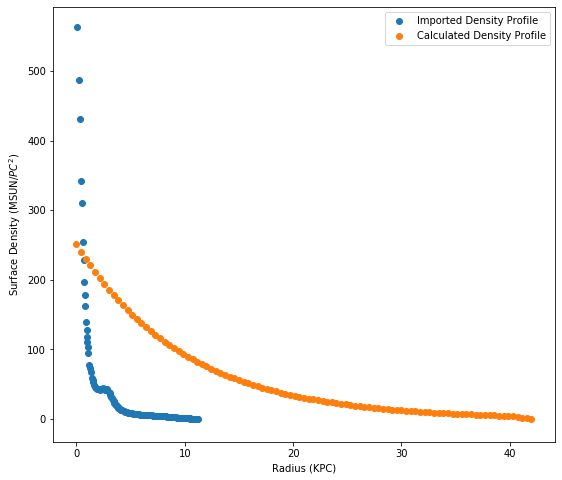

In [4]:
# Plot 
plt.figure(figsize=(9,8))
xdinp_imported = DensityProfile(user=True)[0]
ydinp_imported = DensityProfile(user=True)[1]
plt.scatter(xdinp_imported,ydinp_imported, label="Imported Density Profile")

xdinp_calculated = DensityProfile(user=False)[0]
ydinp_calculated = DensityProfile(user=False)[1]
plt.scatter(xdinp_calculated,ydinp_calculated, label="Calculated Density Profile")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Define radius and density points

In [5]:
xdinp = DensityProfile()[0]
ydinp = DensityProfile()[1]

## Density distribution

In [6]:
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0
#####################################

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0                 # This is multiplied by z0 but in Caserano Eq 2 there isn't any z0
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #mode = input("Which Z density law? 2 or 3 or 4: ")
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

In [7]:
# Casertano Eq 2
def drho_rz(densit,z,z0,mode):
    return densit * denzed(z,z0,mode)  # In Casertano's eq 2, the cosh term is multiplied by rho0(r) 
                                       # so I assume this is the same as the calculated density array

## Functions

In [8]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - (np.sqrt((x**2)-1))

In [9]:
# Complete elliptic integral
def K(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

In [10]:
# Inner function
def innerfunc(r,u,z,densit,z0,mode):
    return (4 * np.pi * G) * (drho_rz(densit,z,z0,mode) * K(r,u,z) * 2 * np.sqrt(u)) / (np.pi * np.sqrt(r * px(r,u,z)))

## Interpolation

In [11]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)

# Calculate the density values at the sampling radii, using Lagrange Interpolation
polynomial = interpd(xdinp,ydinp)        # define the polynomial that's calculated, type: numpy.poly1d
densit = polynomial(radii)               # evaluate values at the sampling radii

In [12]:
print(densit)
print(ydinp)

[5.82141056e+02 5.70194320e+02 5.59918838e+02 ... 3.89374392e-01
 3.82910246e-01 3.76470147e-01]
[5.6363766e+02 4.8707967e+02 4.3151908e+02 3.4158595e+02 3.1031302e+02
 2.5392181e+02 2.2782428e+02 1.9683395e+02 1.7881337e+02 1.6311729e+02
 1.3918742e+02 1.2802654e+02 1.1778772e+02 1.1063690e+02 1.0303861e+02
 9.4362620e+01 7.7250270e+01 7.2861820e+01 6.7873460e+01 5.9634830e+01
 5.6014440e+01 5.3727920e+01 4.8607130e+01 4.6046860e+01 4.4167210e+01
 4.2716930e+01 4.2894340e+01 4.3251380e+01 4.2024250e+01 4.3082410e+01
 4.5112820e+01 4.3651580e+01 4.2043610e+01 4.2933870e+01 4.2579450e+01
 3.8850800e+01 3.6787480e+01 3.4562090e+01 3.1666500e+01 2.9984720e+01
 2.8054340e+01 2.6025560e+01 2.3741050e+01 2.2024190e+01 2.0516350e+01
 1.9511920e+01 1.8176070e+01 1.7072610e+01 1.6173350e+01 1.5317930e+01
 1.4507750e+01 1.3630130e+01 1.2909220e+01 1.2382260e+01 1.1392000e+01
 1.0972360e+01 1.0568180e+01 1.0094850e+01 9.6827800e+00 9.1706500e+00
 8.8715600e+00 8.4722700e+00 8.1959600e+00 7.990980

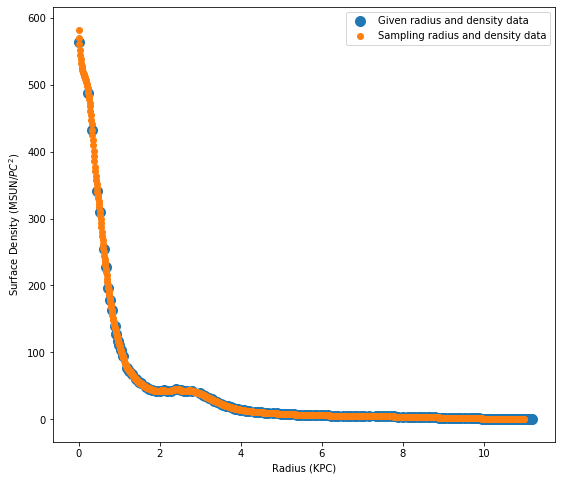

In [13]:
# Plot 
plt.figure(figsize=(9,8))
plt.scatter(xdinp,ydinp, label="Given radius and density data", s=100)
plt.scatter(radii,densit, label="Sampling radius and density data")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Integration

In [ ]:
# Integrate inner function
innerfunc2 = lambda z,r,u,densit,z0,mode: innerfunc(r,u,z,densit,z0,mode)
innerintegr1 = lambda r,u,densit,z0,mode: quad(innerfunc2, 0, np.inf, args=(r,u,densit,z0,mode,))[0]

In [ ]:
# Integrate outer function
innerintegr2 = lambda u,r,densit,z0,mode: innerintegr1(r,u,densit,z0,mode)
radialforce = lambda r,densit,z0,mode: quad(innerintegr2, 0, 125, args=(r,densit,z0,mode,))[0]

## Velocity

In [16]:
radialforce = np.vectorize(radialforce)
velocs = np.sqrt(radii*radialforce(radii,densit,z0,mode))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: Integr

## Plot

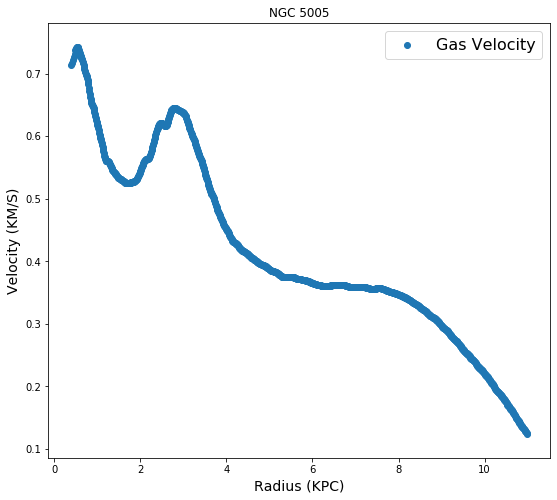

In [17]:
plt.figure(figsize=(9.0,8.0))             
plt.scatter(radii, velocs, linestyle='solid', label='Gas Velocity')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=14)
plt.ylabel('Velocity (KM/S)', fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [18]:
print(radii)
print(velocs)

[1.0000e-03 1.1000e-02 2.1000e-02 ... 1.0971e+01 1.0981e+01 1.0991e+01]
[       nan        nan        nan ... 0.126158   0.12516729 0.12417058]
